# 05 - Time Series Anomaly Detection
This is a lab on time series anomaly detection. We will be using an artificial data courtesy of *Numenta Anomaly Benchmark*, downloaded from https://github.com/numenta/NAB/tree/master/data. This will be simple demonstration on how to perform anomaly detection using autoencoder and how to interpret it.

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## Anomaly Detection using Autoencoder

### Load the data
The characteristics of NAB dataset is that it is consist of artifical timeseries data with labeled anomalies. Since this is a time series data, the data are ordered, timestamped, single-valued metrics.

Inside NAB, there are quite a number of datasets. However, for demonstration sake, we will just use the **art_daily_small_noise.csv** dataset for training and the **art_daily_jumpsup.csv** file for testing. The idea is that the users, through this tutorial, can get a glimpse of how anomaly detection actually works, and how to use deep learning to detect them.

In [2]:
# this is one way of loading data on the fly, just by specifying the URL
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

### Data Exploration
Let's do some exploration and see what nugget can we find out of this dataset!

In [3]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


### Data Visualization
A picture is worth more than a thousand words! This applies to the situation here, too. Visuals can efficiently summarize multiple information in a dataset and present them in an intuitive manner.

#### a) Normal Time Series
Let's plot the dataset that is explicitly stated that there are no anomalous behaviours first. It is going to be our training set for this tutorial. Can you find any anomalous behaviour in the visual below?

Figure(432x288) AxesSubplot(0.125,0.125;0.775x0.755)


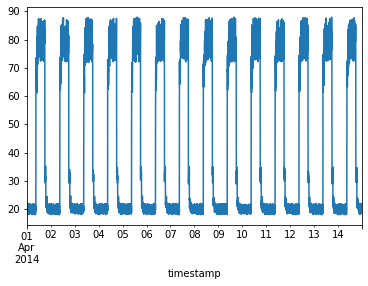

In [6]:
fig, ax = plt.subplots()
print(fig, ax)
df_small_noise.plot(legend=False, ax=ax)
plt.show()

You got it right! It appears to be without anomaly for this set of data.

#### b) Anomalous Time Series
Let's plot another dataset which is explicitly stated that there is anomalous behaviour. It is going to be our testing set for this tutorial to check whether our model can correctly identify anomalous behaviour. Can you identify any anomalous behaviour in the visual below?

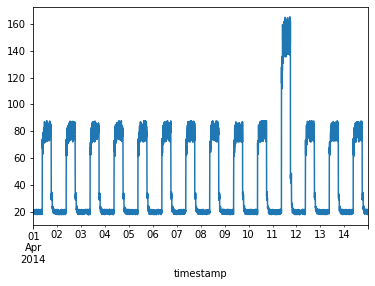

In [7]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

### Pre-processing for Training Set
Since the data is collected at 5-min interval, this means that we have a total of 4032 data points collected for this dataset (since 24 hour * 60 minutes / 5 minutes = 288 data point per day, and the data is collected for a duration of 14 days.
For the sake of science, let us verify this!

In [11]:
print(f"Number of observations for training dataset: {df_daily_jumpsup.shape[0]}")
print(df_daily_jumpsup.tail())

Number of observations for training dataset: 4032
                         value
timestamp                     
2014-04-14 23:35:00  18.074649
2014-04-14 23:40:00  21.002014
2014-04-14 23:45:00  20.566713
2014-04-14 23:50:00  18.254193
2014-04-14 23:55:00  21.863147


Normalization is vital for deep learning model building. Let us not forget to implement this step too! For the spirit of experimentation, let us try to implement this without using Scikit-learn too.

In [22]:
# performing normalization
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
training_set = (df_small_noise - training_mean) / training_std
training_set[:10]

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
2014-04-01 00:25:00,-0.757310
2014-04-01 00:30:00,-0.776456
2014-04-01 00:35:00,-0.788084
2014-04-01 00:40:00,-0.747012


In [23]:
# Standardization
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df_small_noise)
training_set = scaler.transform(df_small_noise)
training_set[:10]

array([[-0.85893509],
       [-0.72908344],
       [-0.84825292],
       [-0.72967628],
       [-0.73126368],
       [-0.75740377],
       [-0.77655271],
       [-0.78818154],
       [-0.74710465],
       [-0.82926884]])

It is vital to prepare our data into a form that is ingestible by our model easily, and time series requires this extra step of turning them into a sequence, which we will demonstrate below.

In [38]:
# defining a function to create sequences with data values 
# and time steps input

time_steps = 288

def create_sequences(values, time_steps = time_steps):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return torch.Tensor(output)

In [39]:
# Calling the create_sequence function

x_train = create_sequences(training_set)
print(f"Shape of training dataset: {x_train.shape}")
x_train.dtype

Shape of training dataset: torch.Size([3744, 288, 1])


torch.float32

Do you know why the training set has a torch.Size of (3744, 288, 1)?\
Because we transformed the data into 3744 rows of observations, each observation having 288 sequence length with 1 feature only.\
Next, we will convert it into Pytorch Dataset instance so that we can turn it into an interator subsequently.

In [40]:
class PytorchDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, x):
        self.x = torch.Tensor(x)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx]

In [42]:
# calling the object to convert training set into Pytorch Dataset instance

train_dataset = PytorchDataset(x_train)

In [44]:
# Sanity check

print(train_dataset[0][0][0])
print(len(train_dataset))
print(len(train_dataset[0]))
print(len(train_dataset[0][0]))

tensor(-0.8589)
3744
288
1


Looks like our transformation work as expected! Let's continue and convert it to a DataLoader then.

In [45]:
# let's use DataLoader built-in for Pytorch to perform batching
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=128,
                                            shuffle=False)

In [46]:
# let's check again by printing out one batch of data

dataiter = iter(train_loader)
sample = next(dataiter)
print(sample.size())
print()

torch.Size([128, 288, 1])



Having an iterator now, we are ready to build our deep learning model for some rock and roll action (like, finally) ! We will be using a convolutional autoencoder for the purpose of anomaly detection.

In [48]:
# let's configure some hyperparameters

epochs = 50
learning_rate = 0.001
random_seed = 42
torch.manual_seed(random_seed)

In [49]:
# define the NN architecture

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1d1 = nn.Conv1d(288, 32, 7, stride=2, padding=3)
        self.dropout1 = nn.Dropout(p=0.2)
        self.conv1d2 = nn.Conv1d(32, 16, 7, stride=2, padding=3)
        self.convtranspose1d1 = nn.ConvTranspose1d(16, 16, 7, stride=2, padding=3)
        self.dropout2 = nn.Dropout(p=0.2)
        self.convtranspose1d2 = nn.ConvTranspose1d(16, 32, 7, stride=2, padding=3)
        self.convtranspose1d3 = nn.ConvTranspose1d(32, 288, 7, stride=2, padding=3)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        x = F.relu(self.conv1d1(x))
        # add second hidden layer
        x = F.relu(self.conv1d2(x))
        x = F.relu(self.convtranspose1d1(x))
        x = F.relu(self.convtranspose1d2(x))
        x = self.convtranspose1d3(x)
                
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1d1): Conv1d(288, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv1d2): Conv1d(32, 16, kernel_size=(7,), stride=(2,), padding=(3,))
  (convtranspose1d1): ConvTranspose1d(16, 16, kernel_size=(7,), stride=(2,), padding=(3,))
  (dropout2): Dropout(p=0.2, inplace=False)
  (convtranspose1d2): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,))
  (convtranspose1d3): ConvTranspose1d(32, 288, kernel_size=(7,), stride=(2,), padding=(3,))
)


In [50]:
# the keeping of shape is important for autoencoder, so let us try to print out shape for each layer

conv1d1 = nn.Conv1d(288, 32, 7, stride=2, padding=3)
dropout1 = nn.Dropout(p=0.2)
conv1d2 = nn.Conv1d(32, 16, 7, stride=2, padding=3)
convtranspose1d1 = nn.ConvTranspose1d(16, 16, 7, stride=2, padding=3)
dropout2 = nn.Dropout(p=0.2)
convtranspose1d2 = nn.ConvTranspose1d(16, 32, 7, stride=2, padding=3)
convtranspose1d3 = nn.ConvTranspose1d(32, 288, 7, stride=2, padding=3)

out = conv1d1(sample)
print(out.shape)
out = conv1d2(out)
print(out.shape)
out = convtranspose1d1(out)
print(out.shape)
out = convtranspose1d2(out)
print(out.shape)
out = convtranspose1d3(out)
print(out.shape)


torch.Size([128, 32, 1])
torch.Size([128, 16, 1])
torch.Size([128, 16, 1])
torch.Size([128, 32, 1])
torch.Size([128, 288, 1])


In [51]:
# let's set loss and optimization function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
# finally we can start to train
n_total_steps = len(train_loader)
print(n_total_steps)

for epoch in range(epochs):
    for i, x in enumerate(train_loader):          
        # forward pass
        outputs = model(x)
        print(x.shape)
        print(outputs.shape)
        loss = criterion(outputs, x) # we are using x as both the input and target because we are trying to measure the loss of our reconstruction model
        
        # backward pass
        optimizer.zero_grad() # this is to clear the parameters, done before each backward pass
        loss.backward()
        optimizer.step()
        
        # print out the training performance
        if (i+1) % 1 == 0:
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():10.4f}')


30
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [1/30], Loss:     0.9913
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [2/30], Loss:     1.0103
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [3/30], Loss:     1.0044
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [4/30], Loss:     0.9879
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [5/30], Loss:     0.9862
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [6/30], Loss:     0.9892
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [7/30], Loss:     0.9896
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [8/30], Loss:     0.9811
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [9/30], Loss:     1.0048
torch.Size([128, 288, 1])
torch.Size([128, 288, 1])
Epoch [1/50], Step [10/30], Loss:     1.0050
torch.Size([128, 288, 1])
torch.Size

### Visualising Results for Model Training
Ideally, we should use Tensorboard for visualizing the training process. However, that's tutorial for another day!

### Anomaly Detection

Recall our anomaly detection model works. We developed a reconstruction model to generate a normal dataset without any anomalous data instances. Next, we need to determine a threshold in order to classify the anomalous points. Finally, we will detect anomalies by fitting our model to the test dataset. So, the steps are summarized below:

1. Compute MAE loss on training samples for our model.  
2. Identify the maximum MAE loss, i.e. the worst performance by our model in its attempt to reconstruct the model. Let's use this as the threshold for anomaly detection (assumption is that this model is 
    unable to generate the normal distribution of data, thus this threshold is also able to rather accurately label anomalous data.
3. Label sample with reconstruction loss more than threshold as anomaly. If reconstruction loss greater than this threshold value, let's infer that the reconstruction model has encountered data behaviours that is abnormal. 

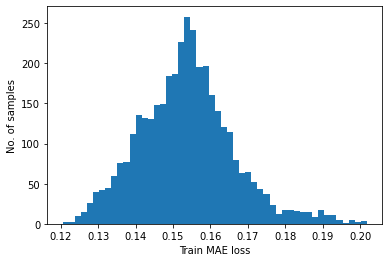

The threshold for reconstruction error is: 0.20177608728408813


In [54]:
with torch.no_grad():
    x_train_pred = model(x_train)
    train_mae_loss = np.mean(np.abs((x_train_pred - x_train).numpy()), axis=1)
                         
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No. of samples")
plt.show()

threshold = np.max(train_mae_loss)
print(f"The threshold for reconstruction error is: {threshold}")

### Comparison of Reconstruction
As a final step, we will compare the reconstruction performed by our model for 288 timesteps from the start of our training set.

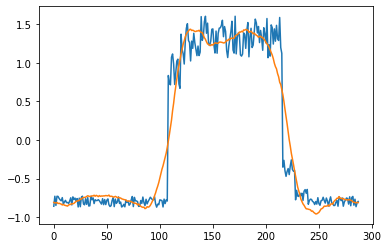

In [55]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Pre-processing of Test Data
Let us also do the necessary pre-processing for our test data.

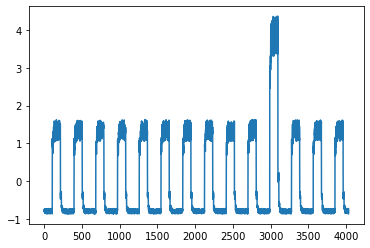

Shape of test input: torch.Size([3744, 288, 1])


In [63]:
# why use training mean and std???
test_set = scaler.transform(df_daily_jumpsup)
fig, ax = plt.subplots()
plt.plot(test_set)
plt.show()

# Calling create_sequence function to transform data
x_test = create_sequences(test_set)
print(f"Shape of test input: {x_test.shape}")

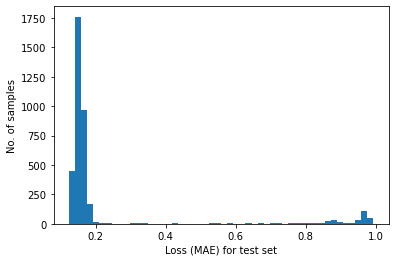

In [64]:
# Compute MAE loss for test set
with torch.no_grad():
    x_test_pred = model(x_test)
    test_mae_loss = np.mean(np.abs((x_test_pred - x_test).numpy()), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

# Visualizing loss
plt.hist(test_mae_loss, bins=50)
plt.xlabel("Loss (MAE) for test set")
plt.ylabel("No. of samples")
plt.show()

### Anomaly Detection
Remember, if the the loss is greater than the threshold, we will label this data as anomaly, and subsequently getting its index in the dataset

In [65]:
anomalies = test_mae_loss > threshold
print(f"Total of anomaly samples: {np.sum(anomalies)}")
print(f"Indices of anomaly samples: {np.where(anomalies)}")

Total of anomaly samples: 385
Indices of anomaly samples: (array([2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716,
       2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
       2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738,
       2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749,
       2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
       2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771,
       2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782,
       2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793,
       2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804,
       2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815,
       2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826,
       2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837,
       2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847

### Anomaly Visualization
Since we know the index of anomalous data, we can also identify the corresponding timestamps from the test dataset. Below is a simple description of how tihs is achieved.

Let's say sequence_length = 3 and we have 10 training values ( 0 ~ 9 ). Our x_train in the processed form will be as below:

* 0, 1, 2
* 1, 2, 3
* 2, 3, 4
* 3, 4, 5
* 4, 5, 6
* 5, 6, 7
* 6, 7, 8
* 7, 8, 9

Other than the initial and the final (time_steps-1) data values, all other data will appear in more than one of the sequences of data. Take an example, if these samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can confidently state that the data instance 5 is an anomaly."

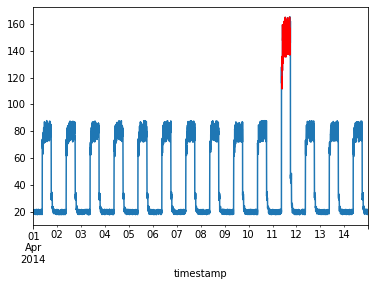

In [66]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(time_steps - 1, len(test_set) - time_steps + 1):
    if np.all(anomalies[data_idx - time_steps + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
        
# overlaying anomalies on original test data plot
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

Source: https://keras.io/examples/timeseries/timeseries_anomaly_detection/